In [2]:
# Importing Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer

import pickle
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

---

# Data Cleaning & Exploration

In [7]:
# Importing Data
data = pd.read_csv(r"2_Naive-Bayes-Text-Classification-Customer-Complaints\Input\complaints.csv")

FileNotFoundError: [Errno 2] No such file or directory: '2_Naive-Bayes-Text-Classification-Customer-Complaints\\Input\\complaints.csv'

In [3]:
data.shape

(2326246, 18)

In [4]:
data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,186XX,NaN,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,NaN,3274605
1,2019-11-01,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,088XX,NaN,Consent provided,Web,2019-11-01,Closed with explanation,Yes,NaN,3425257
2,2019-04-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,NaN,Consent not provided,Web,2019-04-01,Closed with explanation,Yes,NaN,3198225
3,2021-11-01,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",GA,31707,NaN,NaN,Web,2021-11-01,In progress,Yes,NaN,4863965
4,2021-11-02,Debt collection,Medical debt,Took or threatened to take negative or legal a...,Threatened or suggested your credit would be d...,NaN,NaN,"Medical Data Systems, Inc.",VA,22033,NaN,NaN,Web,2021-11-02,In progress,Yes,NaN,4866449


In [5]:
data["Consumer complaint narrative"][13]

'Receiving daily telephone call ( s ) from XXXX XXXX XXXX identifying themselves as from an attorney \'s office and I am unable to decifer the name after asking 3 times. They ask me to confirm that my name is " prior married name ". I ask what they want and they repeat the question. I responded yes and they hang up. \n\nThe next call from that number was asking me if I was a different name - my maiden name which I recently change to. When I asked for clarification, they hung up. \n\nI have received a total of 6 calls in approx 2 days. They never divulge what they want after attempting to verify my name ( s )'

In [6]:
data["Product"][13]

'Credit reporting, credit repair services, or other personal consumer reports'

In [7]:
data["Consumer complaint narrative"][3401]

"I was looking through my report and noticed a vehicle that I returned to the dealership where it's reporting completely incorrect. I had the opportunity to talk to several lawmakers and friends, and learned some basic laws in regards to voluntary or repossession of a vehicle. Under the laws of MASS and UCC 9.506 as well as State RISA and MVISA statutes, a deficiency can not be claimed unless all of the required notices were properly and timely given, and all of the allowable redemption and cure time limits were adhered to. PLEASE HAVE THEM IMMEDIATELY REMOVE"

In [9]:
data["Product"][3401]

'Vehicle loan or lease'

---

### Select only 'product' and 'Consumer complaint narrative' columns

In [10]:
data = data[["Product", "Consumer complaint narrative"]]

In [11]:
data.head()

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",NaN
1,Vehicle loan or lease,I contacted Ally on Friday XX/XX/XXXX after fa...
2,"Credit reporting, credit repair services, or o...",NaN
3,"Credit reporting, credit repair services, or o...",NaN
4,Debt collection,NaN


In [12]:
# Checking for missing values
data.isna().sum()

Product                               0
Consumer complaint narrative    1516903
dtype: int64

---

### Drop records with missing complaints

In [13]:
data.dropna(inplace=True)

<ipython-input-13-f1116dacf2bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [14]:
data.shape

(809343, 2)

In [15]:
# Renaming the "Consumer complaint narrative" column to "Complaint" in the 'data' DataFrame.
data.rename({"Consumer complaint narrative": "Complaint"}, axis=1, inplace=True)


/opt/anaconda3/envs/ppro/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [16]:
data.head()

,Product,Complaint
1,Vehicle loan or lease,I contacted Ally on Friday XX/XX/XXXX after fa...
7,"Credit reporting, credit repair services, or o...",Hello This complaint is against the three cred...
8,"Credit reporting, credit repair services, or o...",I am a victim of Identity Theft & currently ha...
10,"Credit reporting, credit repair services, or o...",Two accounts are still on my credit history af...
13,"Credit reporting, credit repair services, or o...",Receiving daily telephone call ( s ) from XXXX...


In [17]:
data["Product"].unique()

array(['Vehicle loan or lease',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Credit card or prepaid card',
       'Money transfer, virtual currency, or money service', 'Mortgage',
       'Payday loan, title loan, or personal loan', 'Debt collection',
       'Checking or savings account', 'Student loan', 'Consumer Loan',
       'Money transfers', 'Credit card', 'Bank account or service',
       'Credit reporting', 'Prepaid card', 'Payday loan',
       'Other financial service', 'Virtual currency'], dtype=object)

---

### Create unique values for 'product'

In [18]:
product_map = {'Vehicle loan or lease': 'vehicle_loan',
              'Credit reporting, credit repair services, or other personal consumer reports':'credit_report',
              'Credit card or prepaid card': 'card',
              'Money transfer, virtual currency, or money service': 'money_transfer',
              'virtual currency': 'money_transfer',
              'Mortgage': 'mortgage',
               'Payday loan, title loan, or personal loan': 'loan',
               'Debt collection': 'debt_collection',
               'Checking or savings account': 'savings_account',
               'Credit card': 'card',
               'Bank account or service': 'savings_account',
               'Credit reporting': 'credit_report',
               'Prepaid card': 'card',
               'Payday loan': 'loan',
               'Other financial service': 'others',
               'Virtual currency': 'money_transfer',
               'Student loan': 'loan',
               'Consumer Loan': 'loan',
               'Money transfers': 'money_transfer'
              }

In [19]:
# Replace values in the "Product" column using product_map
data.replace({"Product": product_map}, inplace=True)


/opt/anaconda3/envs/ppro/lib/python3.8/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [20]:
data.head()

,Product,Complaint
1,vehicle_loan,I contacted Ally on Friday XX/XX/XXXX after fa...
7,credit_report,Hello This complaint is against the three cred...
8,credit_report,I am a victim of Identity Theft & currently ha...
10,credit_report,Two accounts are still on my credit history af...
13,credit_report,Receiving daily telephone call ( s ) from XXXX...


---

### Plot distribution of 'product' column

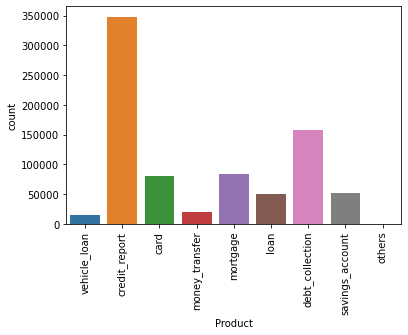

In [21]:
sns.countplot(x="Product", data=data)
plt.xticks(rotation=90)
plt.show()

In [22]:
data["Product"].value_counts()

credit_report      348053
debt_collection    157381
mortgage            84461
card                81042
savings_account     52274
loan                50710
money_transfer      20096
vehicle_loan        15034
others                292
Name: Product, dtype: int64

In [23]:
# Create a list of complaints from the "Complaint" column in the 'data' DataFrame.
complaints = list(data["Complaint"])


In [24]:
len(complaints)

809343

---

### Convert data to lower case

In [25]:
# Convert each complaint in the 'complaints' list to lowercase using a list comprehension.
complaints = [c.lower() for c in tqdm(complaints)]


100%|██████████| 809343/809343 [00:01<00:00, 478258.44it/s]


In [26]:
complaints[13]

'my credit reports list monies owed to xxxx. i have written to the collection agency, xxxx xxxx xxxx requesting proof that i owe monies on this account, but none was ever sent. i notified the credit agencies that this creditor never sent me the required proof, yet they continue to list this account on my credit report. \n\nmy credit reports list xxxx xxxx xxxx and xxxx for monies owed to xxxx. i submitted documentation that showed that the original creditor was paid however, the credit reporting agencies continue to list xxxx xxxx on my credit report. furthermore, two separate collection agencies can not be listed on my creditreport over the same account. \n\nmy credit reports list a bankruptcy that should have been deleted since the 7 years of reporting it has expired.'

In [27]:
complaints[3401]

'xxxx xxxx  sent me a email that it looked like my personal data may had been compromised. i opened it up and reviewed everything and there was several unknown inquiries and accounts that certainly did not belong to me. i pulled my credit to make sure, and these accounts i am reporting are definitely not mine. please remove these items from my report. \n\nbankruptcy chapter xxxx-dismissed xxxx {$0.00}'

---

### Tokenize the text

In [28]:
# Tokenize each complaint in the 'complaints' list using word_tokenize from NLTK,
# and display a progress bar using tqdm.
tokens = [word_tokenize(c) for c in tqdm(complaints)]


100%|██████████| 809343/809343 [15:08<00:00, 890.90it/s] 


In [29]:
tokens[13]

['my',
 'credit',
 'reports',
 'list',
 'monies',
 'owed',
 'to',
 'xxxx',
 '.',
 'i',
 'have',
 'written',
 'to',
 'the',
 'collection',
 'agency',
 ',',
 'xxxx',
 'xxxx',
 'xxxx',
 'requesting',
 'proof',
 'that',
 'i',
 'owe',
 'monies',
 'on',
 'this',
 'account',
 ',',
 'but',
 'none',
 'was',
 'ever',
 'sent',
 '.',
 'i',
 'notified',
 'the',
 'credit',
 'agencies',
 'that',
 'this',
 'creditor',
 'never',
 'sent',
 'me',
 'the',
 'required',
 'proof',
 ',',
 'yet',
 'they',
 'continue',
 'to',
 'list',
 'this',
 'account',
 'on',
 'my',
 'credit',
 'report',
 '.',
 'my',
 'credit',
 'reports',
 'list',
 'xxxx',
 'xxxx',
 'xxxx',
 'and',
 'xxxx',
 'for',
 'monies',
 'owed',
 'to',
 'xxxx',
 '.',
 'i',
 'submitted',
 'documentation',
 'that',
 'showed',
 'that',
 'the',
 'original',
 'creditor',
 'was',
 'paid',
 'however',
 ',',
 'the',
 'credit',
 'reporting',
 'agencies',
 'continue',
 'to',
 'list',
 'xxxx',
 'xxxx',
 'on',
 'my',
 'credit',
 'report',
 '.',
 'furthermore',
 '

In [30]:
tokens[3401]

['xxxx',
 'xxxx',
 'sent',
 'me',
 'a',
 'email',
 'that',
 'it',
 'looked',
 'like',
 'my',
 'personal',
 'data',
 'may',
 'had',
 'been',
 'compromised',
 '.',
 'i',
 'opened',
 'it',
 'up',
 'and',
 'reviewed',
 'everything',
 'and',
 'there',
 'was',
 'several',
 'unknown',
 'inquiries',
 'and',
 'accounts',
 'that',
 'certainly',
 'did',
 'not',
 'belong',
 'to',
 'me',
 '.',
 'i',
 'pulled',
 'my',
 'credit',
 'to',
 'make',
 'sure',
 ',',
 'and',
 'these',
 'accounts',
 'i',
 'am',
 'reporting',
 'are',
 'definitely',
 'not',
 'mine',
 '.',
 'please',
 'remove',
 'these',
 'items',
 'from',
 'my',
 'report',
 '.',
 'bankruptcy',
 'chapter',
 'xxxx-dismissed',
 'xxxx',
 '{',
 '$',
 '0.00',
 '}']

---

### Remove stop words

In [31]:
sw = stopwords.words("english")

In [33]:
sw[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [34]:
# Remove stopwords from each tokenized complaint in the 'tokens' list,
# and display a progress bar using tqdm.
tokens = [[word for word in t if word not in sw] for t in tqdm(tokens)]


100%|██████████| 809343/809343 [07:23<00:00, 1824.44it/s] 


---

### Remove punctuation marks

In [35]:
# Create a regular expression-based word tokenizer that tokenizes by word characters (alphanumeric characters).
tokenizer = RegexpTokenizer(r'\w+')


In [36]:
# Tokenize each word in the 'tokens' list using the RegexpTokenizer,
# remove empty tokens, and display a progress bar using tqdm.
tokens = [["".join(tokenizer.tokenize(word)) for word in t if len(tokenizer.tokenize(word)) > 0] for t in tqdm(tokens)]


100%|██████████| 809343/809343 [05:48<00:00, 2325.34it/s] 


In [37]:
tokens[13]

['credit',
 'reports',
 'list',
 'monies',
 'owed',
 'xxxx',
 'written',
 'collection',
 'agency',
 'xxxx',
 'xxxx',
 'xxxx',
 'requesting',
 'proof',
 'owe',
 'monies',
 'account',
 'none',
 'ever',
 'sent',
 'notified',
 'credit',
 'agencies',
 'creditor',
 'never',
 'sent',
 'required',
 'proof',
 'yet',
 'continue',
 'list',
 'account',
 'credit',
 'report',
 'credit',
 'reports',
 'list',
 'xxxx',
 'xxxx',
 'xxxx',
 'xxxx',
 'monies',
 'owed',
 'xxxx',
 'submitted',
 'documentation',
 'showed',
 'original',
 'creditor',
 'paid',
 'however',
 'credit',
 'reporting',
 'agencies',
 'continue',
 'list',
 'xxxx',
 'xxxx',
 'credit',
 'report',
 'furthermore',
 'two',
 'separate',
 'collection',
 'agencies',
 'listed',
 'creditreport',
 'account',
 'credit',
 'reports',
 'list',
 'bankruptcy',
 'deleted',
 'since',
 '7',
 'years',
 'reporting',
 'expired']

In [38]:
tokens[3401]

['xxxx',
 'xxxx',
 'sent',
 'email',
 'looked',
 'like',
 'personal',
 'data',
 'may',
 'compromised',
 'opened',
 'reviewed',
 'everything',
 'several',
 'unknown',
 'inquiries',
 'accounts',
 'certainly',
 'belong',
 'pulled',
 'credit',
 'make',
 'sure',
 'accounts',
 'reporting',
 'definitely',
 'mine',
 'please',
 'remove',
 'items',
 'report',
 'bankruptcy',
 'chapter',
 'xxxxdismissed',
 'xxxx',
 '000']

---

### Remove 'xxxx' and '000' tokens

In [39]:
# Remove specific tokens ('xxxx' and '000') from each list of tokens in the 'tokens' list,
# and display a progress bar using tqdm.
tokens = [[t for t in token if t not in ['xxxx', '000']] for token in tqdm(tokens)]


100%|██████████| 809343/809343 [02:20<00:00, 5773.08it/s] 


In [40]:
tokens[13]

['credit',
 'reports',
 'list',
 'monies',
 'owed',
 'written',
 'collection',
 'agency',
 'requesting',
 'proof',
 'owe',
 'monies',
 'account',
 'none',
 'ever',
 'sent',
 'notified',
 'credit',
 'agencies',
 'creditor',
 'never',
 'sent',
 'required',
 'proof',
 'yet',
 'continue',
 'list',
 'account',
 'credit',
 'report',
 'credit',
 'reports',
 'list',
 'monies',
 'owed',
 'submitted',
 'documentation',
 'showed',
 'original',
 'creditor',
 'paid',
 'however',
 'credit',
 'reporting',
 'agencies',
 'continue',
 'list',
 'credit',
 'report',
 'furthermore',
 'two',
 'separate',
 'collection',
 'agencies',
 'listed',
 'creditreport',
 'account',
 'credit',
 'reports',
 'list',
 'bankruptcy',
 'deleted',
 'since',
 '7',
 'years',
 'reporting',
 'expired']

In [41]:
tokens[3401]

['sent',
 'email',
 'looked',
 'like',
 'personal',
 'data',
 'may',
 'compromised',
 'opened',
 'reviewed',
 'everything',
 'several',
 'unknown',
 'inquiries',
 'accounts',
 'certainly',
 'belong',
 'pulled',
 'credit',
 'make',
 'sure',
 'accounts',
 'reporting',
 'definitely',
 'mine',
 'please',
 'remove',
 'items',
 'report',
 'bankruptcy',
 'chapter',
 'xxxxdismissed']

---

### Check word count for couple of classes

In [47]:
# Add a new column "clean_complaints" to the 'data' DataFrame and populate it with the 'tokens'.
data["clean_complaints"] = tokens


<ipython-input-47-9ba6f2e602ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["clean_complaints"] = tokens


In [48]:
data.head()

,Product,Complaint,clean_complaints
1,vehicle_loan,I contacted Ally on Friday XX/XX/XXXX after fa...,"[contacted, ally, friday, xxxxxxxx, falling, b..."
7,credit_report,Hello This complaint is against the three cred...,"[hello, complaint, three, credit, reporting, c..."
8,credit_report,I am a victim of Identity Theft & currently ha...,"[victim, identity, theft, currently, experian,..."
10,credit_report,Two accounts are still on my credit history af...,"[two, accounts, still, credit, history, contac..."
13,credit_report,Receiving daily telephone call ( s ) from XXXX...,"[receiving, daily, telephone, call, identifyin..."


In [49]:
# Create a list of "clean_complaints" for the subset of data where the "Product" is "loan".
loan_complaints = list(data[data["Product"] == "loan"]["clean_complaints"])


In [50]:
# Flatten the list of tokens within "loan_complaints" using list comprehension and display a progress bar.
loan_complaints = [token for complaint in tqdm(loan_complaints) for token in complaint]


100%|██████████| 50710/50710 [00:04<00:00, 10577.12it/s]


In [51]:
# Create a counter to count the frequency of each token in the "loan_complaints" list.
counter = Counter(loan_complaints)


In [52]:
counter.most_common(10)

[('loan', 108721),
 ('payment', 69612),
 ('xxxxxxxx', 54859),
 ('payments', 54658),
 ('would', 51778),
 ('loans', 49381),
 ('account', 44823),
 ('credit', 40709),
 ('told', 38378),
 ('pay', 36730)]

In [53]:
# Create a list of "clean_complaints" for the subset of data where the "Product" is "card".
card_complaints = list(data[data["Product"] == "card"]["clean_complaints"])


In [54]:
# Flatten the list of tokens within "card_complaints" using list comprehension and display a progress bar.
card_complaints = [token for complaint in tqdm(card_complaints) for token in complaint]


100%|██████████| 81042/81042 [00:04<00:00, 17850.42it/s]


In [55]:
# Create a counter to count the frequency of each token in the "card_complaints" list.
counter = Counter(card_complaints)


In [56]:
counter.most_common(10)

[('card', 188911),
 ('credit', 180949),
 ('account', 143171),
 ('xxxxxxxx', 95253),
 ('would', 74332),
 ('bank', 68126),
 ('payment', 68015),
 ('told', 57508),
 ('called', 53979),
 ('one', 53750)]

In [57]:
# Create a counter to count the frequency of each token in the flattened list of "tokens" and display a progress bar.
counter = Counter([t for complaint in tqdm(tokens) for t in complaint])


100%|██████████| 809343/809343 [00:21<00:00, 38152.61it/s]


In [58]:
counter.most_common(10)

[('credit', 1371264),
 ('account', 1098988),
 ('xxxxxxxx', 889650),
 ('report', 632326),
 ('information', 584507),
 ('would', 478585),
 ('payment', 472922),
 ('loan', 425411),
 ('debt', 413992),
 ('bank', 379931)]

In [59]:
len(counter.keys())

243338

In [60]:
# Join the tokens in each "tokens" list into a single string, separated by spaces, and display a progress bar.
clean_complaints = [" ".join(complaint) for complaint in tqdm(tokens)]


100%|██████████| 809343/809343 [00:18<00:00, 43518.58it/s]


In [61]:
clean_complaints[13]

'credit reports list monies owed written collection agency requesting proof owe monies account none ever sent notified credit agencies creditor never sent required proof yet continue list account credit report credit reports list monies owed submitted documentation showed original creditor paid however credit reporting agencies continue list credit report furthermore two separate collection agencies listed creditreport account credit reports list bankruptcy deleted since 7 years reporting expired'

In [62]:
clean_complaints[3401]

'sent email looked like personal data may compromised opened reviewed everything several unknown inquiries accounts certainly belong pulled credit make sure accounts reporting definitely mine please remove items report bankruptcy chapter xxxxdismissed'

---

# Data Preparation

### Vectorize the data

In [63]:
# Create a CountVectorizer with a minimum document frequency (min_df) of 200.
vect = CountVectorizer(min_df=200)


In [64]:
# Fit the CountVectorizer on the "clean_complaints" data and transform it into a document-term matrix (X).
X = vect.fit_transform(clean_complaints)


In [65]:
X.shape

(809343, 8547)

In [66]:
y = data["Product"]

---

### Split the data into train and test

In [68]:
# Split the data into training and testing sets, with a test size of 20%,
# ensuring stratified sampling, and setting a random seed for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [69]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(647474, 8547) (647474,) (161869, 8547) (161869,)


---

# Model Training

### Create a multi-nomial Naive Bayes' Model

In [70]:
# Create a Multinomial Naive Bayes (MultinomialNB) model.
model = MultinomialNB()


In [71]:
model.fit(X_train, y_train)

MultinomialNB()

### Predict on test set

In [72]:
# Use the trained model to make predictions on the test data (X_test).
test_pred = model.predict(X_test)


In [73]:
accuracy_score(y_test, test_pred)

0.787371269359791

---

### Visualize confusion matrix

In [74]:
conf_mat = confusion_matrix(y_test, test_pred)

In [75]:
conf_mat

array([[12285,  1137,   422,   358,   522,    63,    16,  1254,   152],
       [ 3126, 56518,  4646,  1578,   240,  1071,    61,   410,  1961],
       [ 1091,  4539, 22698,  1481,   131,   555,    30,   332,   619],
       [  296,   519,   633,  6966,    91,   246,    17,   229,  1145],
       [  154,    18,    29,    27,  3207,    36,    25,   516,     7],
       [  164,   354,   198,   364,    65, 15383,    16,   235,   113],
       [    3,     0,     4,    19,     4,     4,     7,    17,     0],
       [  777,   182,    93,    73,   877,   159,    18,  8217,    59],
       [   70,   261,   115,   295,     4,    41,     3,    48,  2170]])

In [76]:
# Create a confusion matrix DataFrame using the 'conf_mat' data, 
# with class labels as both columns and rows.
conf_mat = pd.DataFrame(conf_mat, columns=model.classes_, index=model.classes_)


In [77]:
conf_mat

,card,credit_report,debt_collection,loan,money_transfer,mortgage,others,savings_account,vehicle_loan
card,12285,1137,422,358,522,63,16,1254,152
credit_report,3126,56518,4646,1578,240,1071,61,410,1961
debt_collection,1091,4539,22698,1481,131,555,30,332,619
loan,296,519,633,6966,91,246,17,229,1145
money_transfer,154,18,29,27,3207,36,25,516,7
mortgage,164,354,198,364,65,15383,16,235,113
others,3,0,4,19,4,4,7,17,0
savings_account,777,182,93,73,877,159,18,8217,59
vehicle_loan,70,261,115,295,4,41,3,48,2170


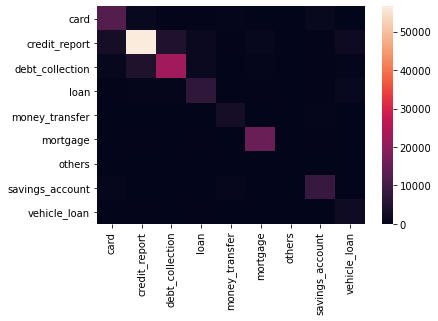

In [78]:
sns.heatmap(conf_mat)
plt.show()

### Save vectorizer and model object

In [79]:
# Save the CountVectorizer and Multinomial Naive Bayes (MultinomialNB) model using Pickle.
with open("Output/count_vect.pkl", "wb") as f:
    pickle.dump(vect, f)

with open("Output/nb.pkl", "wb") as f:
    pickle.dump(model, f)


---

# Prediction

In [80]:
data["Complaint"][1545]

'I have a debt of Bank of America which was written off by the bank XX/XX/XXXX without my knowledge. I went to the bank XXXX XXXX since a law group kept on delving on XXXX XXXX Clerk File and garnishing salary from my work.This case has been closed.I paid a lesser amount to the bank to close this debt XXXX I sent them checks. I will greatly appreciate if this case will be resolve.'

In [81]:
data["Product"][1545]

'debt_collection'

In [82]:
data["Complaint"][5001]

'This is a personal Delta American Express charge card. I am a 30 year customer with American Express. I suddenly, without notice or warning have noted that " Charging Privileges Have Been Suspended \'\'. The card is current, with no money owed. This notice is only available online and I never received ANY written advice of this action. My account is not " paperless \'\'. At the phone number provided to call for information, after nearly an hour on the phone THREE TIMES, no explanation was ever provided and I was advised I " would be contacted \'\' to explain the ( lack of ) issue. I was never contacted. I had accumulated miles points on the card that I can not access and my charge privileges have been suspended. I am unable to obtain any information.'

In [83]:
data["Product"][5001]

'card'

In [84]:
test_complaint_1 = data["Complaint"][1545]
test_complaint_2 = data["Complaint"][5001]

In [85]:
test_complaint = [test_complaint_1, test_complaint_2]

### Load the vectorizer and model objects

In [86]:
# Load the previously saved CountVectorizer and Multinomial Naive Bayes (MultinomialNB) model using Pickle.
vect = pickle.load(open("Output/count_vect.pkl", "rb"))
model = pickle.load(open("Output/nb.pkl", "rb"))


### Process test data

In [88]:
# Convert each element in the 'test_complaint' list to lowercase.
test_complaint = [r.lower() for r in test_complaint]

In [89]:
test_complaint

['i have a debt of bank of america which was written off by the bank xx/xx/xxxx without my knowledge. i went to the bank xxxx xxxx since a law group kept on delving on xxxx xxxx clerk file and garnishing salary from my work.this case has been closed.i paid a lesser amount to the bank to close this debt xxxx i sent them checks. i will greatly appreciate if this case will be resolve.',
 'this is a personal delta american express charge card. i am a 30 year customer with american express. i suddenly, without notice or warning have noted that " charging privileges have been suspended \'\'. the card is current, with no money owed. this notice is only available online and i never received any written advice of this action. my account is not " paperless \'\'. at the phone number provided to call for information, after nearly an hour on the phone three times, no explanation was ever provided and i was advised i " would be contacted \'\' to explain the ( lack of ) issue. i was never contacted. 

In [90]:
# Tokenize each complaint in the 'test_complaint' list using word_tokenize from NLTK.
test_tokens = [word_tokenize(r) for r in test_complaint]


In [91]:
# Remove stopwords from each tokenized complaint in the 'test_tokens' list.
test_tokens = [[word for word in t if word not in sw] for t in test_tokens]


In [92]:
# Tokenize each word in the 'test_tokens' list using the RegexpTokenizer,
# remove empty tokens, and join valid tokens.
test_tokens = [["".join(tokenizer.tokenize(word)) for word in t if len(tokenizer.tokenize(word)) > 0] for t in test_tokens]


In [93]:
# Remove specific tokens ("xxxx" and "000") from each list of tokens in the 'test_tokens' list.
test_tokens = [[t for t in token if t not in ["xxxx", "000"]] for token in test_tokens]


In [94]:
# Join the tokens in each "test_tokens" list into a single string, separated by spaces.
clean_test_complaints = [" ".join(complaint) for complaint in test_tokens]


### Vectorize test data

In [95]:
# Transform the "clean_test_complaints" using the pre-fitted CountVectorizer (vect) into a document-term matrix (X_test).
X_test = vect.transform(clean_test_complaints)


### Make predictions

In [96]:
model.predict(X_test)

array(['debt_collection', 'card'], dtype='<U15')

---